IE552 Neural Differential Equations Final

20245537 JaeHyeon, An

Paper review: Neural Controlled Differential Equations for Online Prediction Tasks

In this code, we compare the train loss of natural cubic spline versus hermite cubic spline.

Ornstein-Uhlenbeck process is used as a dataset, which has properties:

mean-reverting, temporal correlation.

It is often used in financial modeling and physics with particle displacement.



---

Natural Cubic Spline

---



In [ ]:
!pip install torchcde

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchcde
import torchsde
from torch.utils.data import Dataset, DataLoader

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
def ou_process(T, N, theta, mu, sigma, X0):
    """
    Simulate the Ornstein-Uhlenbeck process.

    Parameters:
    T (float): Total time.
    N (int): Number of time steps.
    theta (float): Rate of mean reversion.
    mu (float): Long-term mean.
    sigma (float): Volatility.
    X0 (float): Initial value.

    Returns:
    np.ndarray: Simulated values of the OU process.
    """
    dt = T / N
    t = np.linspace(0, T, N)
    X = np.zeros(N)
    X[0] = X0

    for i in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))
        X[i] = X[i-1] + theta * (mu - X[i-1]) * dt + sigma * dW

    return t, X

def generate_data(num_samples, T, N, theta, mu, sigma, X0):
    data_list = []
    for _ in range(num_samples):
        t, X = ou_process(T, N, theta, mu, sigma, X0)
        data_list.append([t, X])

    total_data = torch.Tensor(np.array(data_list))
    total_data = total_data.permute(0, 2, 1)

    max_len = total_data.shape[1]
    times = torch.linspace(0, 1, max_len)
    coeffs = torchcde.natural_cubic_spline_coeffs(total_data, times)

    return total_data, coeffs, times

class OU_Dataset(Dataset):
    def __init__(self, data, coeffs):
        self.data = data
        self.coeffs = coeffs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            self.data[idx, ...],
            self.coeffs[idx, ...],
        )

def split_data(data, coeffs, train_ratio=0.8):
    total_size = len(data)
    train_size = int(total_size * train_ratio)

    train_idx = np.random.choice(range(total_size), train_size, replace=False)
    test_idx = np.array([i for i in range(total_size) if i not in train_idx])

    train_data = data[train_idx, ...]
    test_data = data[test_idx, ...]
    train_coeffs = coeffs[train_idx, ...]
    test_coeffs = coeffs[test_idx, ...]

    return train_data, train_coeffs, test_data, test_coeffs

def create_data_loaders(train_data, train_coeffs, test_data, test_coeffs, batch_size=16):
    train_dataset = OU_Dataset(train_data, train_coeffs)
    test_dataset = OU_Dataset(test_data, test_coeffs)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Parameters
config = {
    'num_samples': 300,
    'T': 10.0,
    'N': 200,
    'theta': 0.25,
    'mu': 0.0,
    'sigma': 0.2,
    'X0': 1.0,
    'train_ratio': 0.8,
    'batch_size': 16,
    'seed': 44,
}

# Ensure reproducibility
seed_everything(config['seed'])

# Generate data
total_data, coeffs, times = generate_data(config['num_samples'], config['T'], config['N'], config['theta'], config['mu'], config['sigma'], config['X0'])

# Split data
train_data, train_coeffs, test_data, test_coeffs = split_data(total_data, coeffs, config['train_ratio'])

# Create data loaders
train_loader, test_loader = create_data_loaders(train_data, train_coeffs, test_data, test_coeffs, config['batch_size'])

In [3]:
class LipSwish(nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)

class MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_dim, num_layers, tanh=True, activation='lipswish'):
        super().__init__()

        if activation == 'lipswish':
            activation_fn = LipSwish()
        else:
            activation_fn = nn.ReLU()

        model = [nn.Linear(in_size, hidden_dim), activation_fn]
        for _ in range(num_layers - 1):
            model.append(nn.Linear(hidden_dim, hidden_dim))
            model.append(activation_fn)
        model.append(nn.Linear(hidden_dim, out_size))
        if tanh:
            model.append(nn.Tanh())
        self._model = nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

class NeuralCDEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_hidden_dim, num_layers, activation='lipswish'):
        super(NeuralCDEFunc, self).__init__()
        self.sde_type = "ito"
        self.noise_type = "scalar"

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.linear_in = nn.Linear(hidden_dim + 1, hidden_dim)
        self.f_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers, activation=activation)
        self.linear_out = nn.Linear(hidden_dim, input_dim * hidden_dim)

    def set_X(self, coeffs, times):
        self.coeffs = coeffs
        self.times = times
        self.X = torchcde.CubicSpline(self.coeffs, self.times)

    def forward(self, t, y):
        if t.dim() == 0:
            t_scalar = t.item() if t.dim() == 0 else t
            t = torch.full_like(y[:, 0], fill_value=t_scalar).unsqueeze(-1)
        yy = self.linear_in(torch.cat((t, y), dim=-1))
        yy = self.f_net(yy)
        return self.linear_out(yy).view(yy.shape[0], self.hidden_dim, self.input_dim)

class NDE_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation='lipswish', vector_field=None):
        super(NDE_model, self).__init__()
        self.func = vector_field(input_dim, hidden_dim, hidden_dim, num_layers, activation=activation)
        self.initial = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, coeffs, times):
        self.func.set_X(coeffs, times)

        y0 = self.func.X.evaluate(times[0])
        y0 = self.initial(y0)

        z = torchcde.cdeint(X=self.func.X,
                            func=self.func,
                            z0=y0,
                            t=times,
                            dt=0.1,
                            method='euler',
                            backend='torchsde')
        return self.decoder(z)

input_dim = 2
output_dim = 1
hidden_dim = 32
num_layers = 1

num_epochs = 100
lr = 1e-3

In [ ]:
lossCDE = []

model = NDE_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, vector_field=NeuralCDEFunc).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

for epoch in range(1,num_epochs+1):
    model.train()
    total_loss = 0
    for batch in train_loader:
        coeffs = batch[1].to(device)
        times = torch.linspace(0, 1, batch[0].shape[1]).to(device)

        optimizer.zero_grad()
        true = batch[0][:,:,1].to(device)
        pred = model(coeffs, times).squeeze(-1)
        loss = criterion(pred, true)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    lossCDE.append(total_loss)
    if epoch % 10 == 0:
        avg_loss = total_loss / len(train_loader)

        ##
        model.eval()
        total_loss = 0
        all_preds = []
        all_trues = []
        with torch.no_grad():
            for batch in test_loader:
                coeffs = batch[1].to(device)
                times = torch.linspace(0, 1, batch[0].shape[1]).to(device)

                true = batch[0][:,:,1].to(device)
                pred = model(coeffs, times).squeeze(-1)
                loss = criterion(pred, true)
                total_loss += loss.item()

                all_preds.append(pred.cpu())
                all_trues.append(true.cpu())

        avg_loss = total_loss / len(test_loader)
        all_preds = torch.cat(all_preds, dim=0)
        all_trues = torch.cat(all_trues, dim=0)

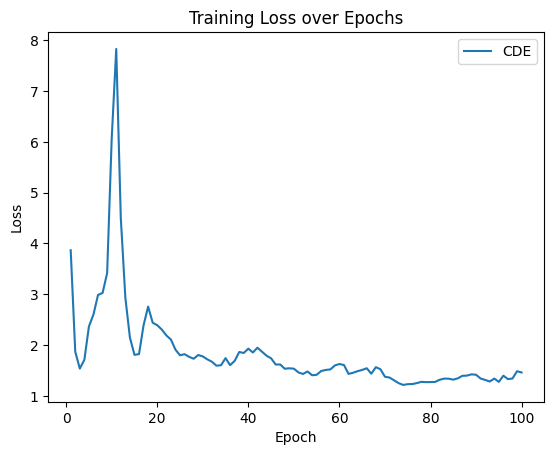

In [6]:
plt.plot(range(1, num_epochs+1), lossCDE, label = 'CDE')
plt.legend(loc='upper right')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [7]:
# Print train loss
lossCDE[-1]

1.4614555016160011



---

Hermite cubic spline with backward differences

---



In [10]:
def ou_process(T, N, theta, mu, sigma, X0):
    """
    Simulate the Ornstein-Uhlenbeck process.

    Parameters:
    T (float): Total time.
    N (int): Number of time steps.
    theta (float): Rate of mean reversion.
    mu (float): Long-term mean.
    sigma (float): Volatility.
    X0 (float): Initial value.

    Returns:
    np.ndarray: Simulated values of the OU process.
    """
    dt = T / N
    t = np.linspace(0, T, N)
    X = np.zeros(N)
    X[0] = X0

    for i in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))
        X[i] = X[i-1] + theta * (mu - X[i-1]) * dt + sigma * dW

    return t, X

def generate_data(num_samples, T, N, theta, mu, sigma, X0):
    data_list = []
    for _ in range(num_samples):
        t, X = ou_process(T, N, theta, mu, sigma, X0)
        data_list.append([t, X])

    total_data = torch.Tensor(np.array(data_list))
    total_data = total_data.permute(0, 2, 1)

    max_len = total_data.shape[1]
    times = torch.linspace(0, 1, max_len)
    coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(total_data, times)

    return total_data, coeffs, times

class OU_Dataset(Dataset):
    def __init__(self, data, coeffs):
        self.data = data
        self.coeffs = coeffs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            self.data[idx, ...],
            self.coeffs[idx, ...],
        )

def split_data(data, coeffs, train_ratio=0.8):
    total_size = len(data)
    train_size = int(total_size * train_ratio)

    train_idx = np.random.choice(range(total_size), train_size, replace=False)
    test_idx = np.array([i for i in range(total_size) if i not in train_idx])

    train_data = data[train_idx, ...]
    test_data = data[test_idx, ...]
    train_coeffs = coeffs[train_idx, ...]
    test_coeffs = coeffs[test_idx, ...]

    return train_data, train_coeffs, test_data, test_coeffs

def create_data_loaders(train_data, train_coeffs, test_data, test_coeffs, batch_size=16):
    train_dataset = OU_Dataset(train_data, train_coeffs)
    test_dataset = OU_Dataset(test_data, test_coeffs)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Parameters
config = {
    'num_samples': 300,
    'T': 10.0,
    'N': 200,
    'theta': 0.25,
    'mu': 0.0,
    'sigma': 0.2,
    'X0': 1.0,
    'train_ratio': 0.8,
    'batch_size': 16,
    'seed': 44,
}

# Ensure reproducibility
seed_everything(config['seed'])

# Generate data
total_data, coeffs, times = generate_data(config['num_samples'], config['T'], config['N'], config['theta'], config['mu'], config['sigma'], config['X0'])

# Split data
train_data, train_coeffs, test_data, test_coeffs = split_data(total_data, coeffs, config['train_ratio'])

# Create data loaders
train_loader, test_loader = create_data_loaders(train_data, train_coeffs, test_data, test_coeffs, config['batch_size'])

In [ ]:
lossCDE = []

model = NDE_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, vector_field=NeuralCDEFunc).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

for epoch in range(1,num_epochs+1):
    model.train()
    total_loss = 0
    for batch in train_loader:
        coeffs = batch[1].to(device)
        times = torch.linspace(0, 1, batch[0].shape[1]).to(device)

        optimizer.zero_grad()
        true = batch[0][:,:,1].to(device)
        pred = model(coeffs, times).squeeze(-1)
        loss = criterion(pred, true)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    lossCDE.append(total_loss)
    if epoch % 10 == 0:
        avg_loss = total_loss / len(train_loader)

        ##
        model.eval()
        total_loss = 0
        all_preds = []
        all_trues = []
        with torch.no_grad():
            for batch in test_loader:
                coeffs = batch[1].to(device)
                times = torch.linspace(0, 1, batch[0].shape[1]).to(device)

                true = batch[0][:,:,1].to(device)
                pred = model(coeffs, times).squeeze(-1)
                loss = criterion(pred, true)
                total_loss += loss.item()

                all_preds.append(pred.cpu())
                all_trues.append(true.cpu())

        avg_loss = total_loss / len(test_loader)
        all_preds = torch.cat(all_preds, dim=0)
        all_trues = torch.cat(all_trues, dim=0)

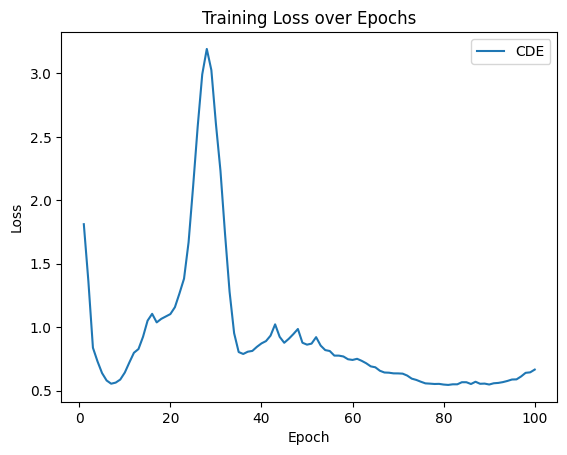

In [12]:
plt.plot(range(1, num_epochs+1), lossCDE, label = 'CDE')
plt.legend(loc='upper right')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [13]:
# Print train loss
lossCDE[-1]

0.6653637811541557

So we can see that Hermite cubic spline really gets better accuracy than the natural cubic spline.